In [2]:
import numpy as np
import pylab as plt
import h5py
from skimage.segmentation import random_walker

import data_manager as dm
from skimage.filters import median
from skimage.filters.rank import mean
from skimage.morphology import ball

In [5]:
n_slices = 100
sample_name = "gecko_123438"

In [3]:
#data = dm.load_data_server(sample_name, [10, n_slices])
img3d = dm.assemble_3d_database("crop_gecko_123438")
thrs1 = np.percentile(img3d.flat[::5], 99)
thrs2 = np.percentile(img3d.flat[::5], 50)

thrs1, thrs2

(0.00043057350732851737, 1.843387508415617e-05)

In [4]:
data = img3d[:100, 500:600, 500:600]

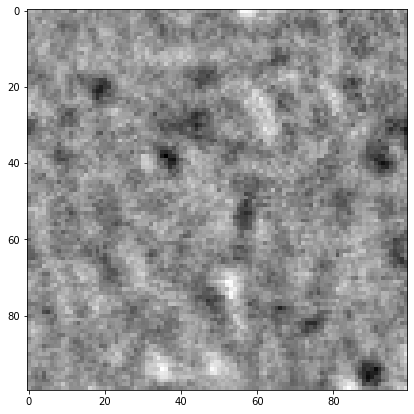

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(data.take(25, 1), cmap="gray")

In [6]:
data = median(data, selem=ball(1))

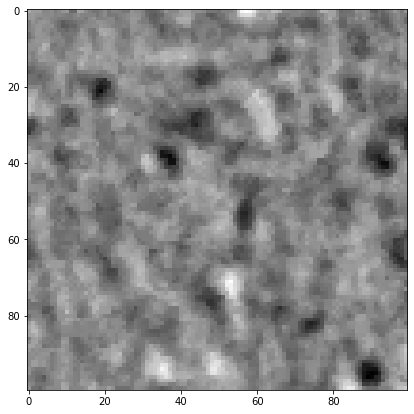

In [7]:
plt.figure(figsize=(7,7))
plt.imshow(data.take(25, 1), cmap="gray")

In [8]:
def clean_data(data):
    markers = np.zeros_like(data)
    markers[data > thrs1] = 1
    markers[data < thrs2] = 2
    t = random_walker(data, markers, beta=100)
    
    return t

In [9]:
#data_t = data[100:150,100:150,100:150]
data_clean = clean_data(data)

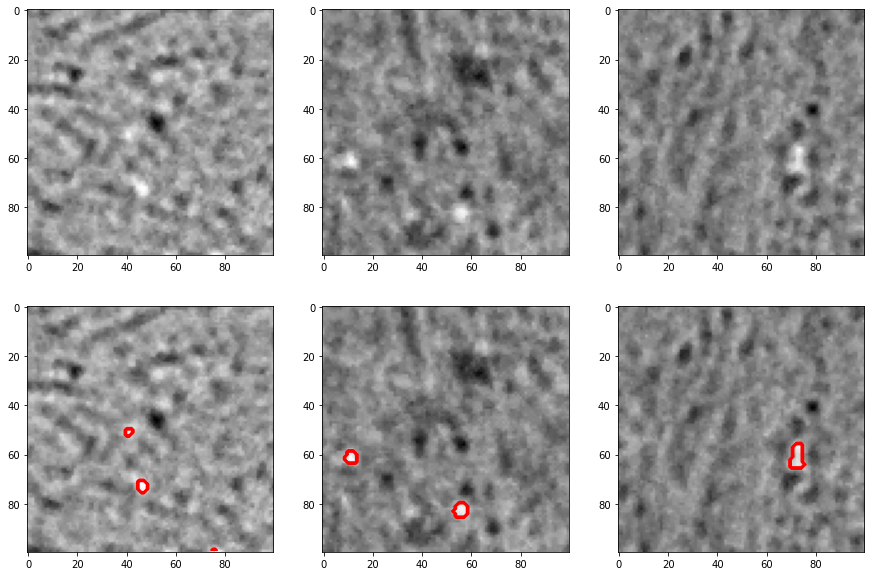

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.T

for N, ax in zip(range(3), axes):
    slice_num = 20
    ax[0].imshow(data.take(slice_num, N), cmap="gray")
    ax[1].imshow(data.take(slice_num, N), cmap="gray")
    ax[1].contour(data_clean.take(slice_num, N), colors=["red"])

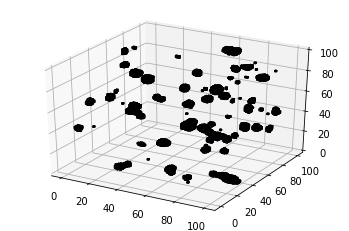

In [12]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(data_clean==1, edgecolor='k')

In [13]:
(data_clean==1).sum()/data_clean.size

0.004397

In [17]:
def create_mask3(img):
    thrs1 = np.percentile(img.flat[::5], 5)
    thrs2 = np.percentile(img.flat[::5], 95)  
    
#     need_squeeze = False
#     if img.ndim == 2:
#         need_squeeze = True
#         img = img[np.newaxis,:,:]
    res = np.zeros_like(img)
    N = 3
    overlap = 5
    border = np.rint(np.linspace(0, img.shape, N+1, True)).T.astype(int)
    b0_orig = border[:,:-1].copy()
    b0_orig[:,1:] = overlap
    x0_orig, y0_orig, z0_orig = b0_orig
    
    b0 = border[:,:-1].copy()
    b0[:,1:]-=overlap
    x0, y0, z0 = b0
    
    b1_orig = border[:,1:].copy()
    b1_orig[:, :-1] = overlap
    b1_orig[:,-1] = 0
    x1_orig, y1_orig, z1_orig = b1_orig
    
    b1 = border[:,1:].copy()
    b1[:, :-1]+=overlap
    x1, y1, z1 = b1
            
    for ix in range(len(x0)):
        for iy in range(len(y0)):
            for iz in range(len(z0)):
                t_img = img[x0[ix]:x1[ix],
                            y0[iy]:y1[iy],
                            z0[iz]:z1[iz]]
                markers = np.zeros_like(t_img)
                markers[t_img > thrs1] = 1
                markers[t_img < thrs2] = 2
                rt = random_walker(t_img, markers, beta=1)
#                 x11 = x1_orig[ix] if not x1_orig[ix] == 0 else 1
#                 y11 = y1_orig[iy] if not y1_orig[iy] == 0 else 1
#                 z11 = z1_orig[iz] if not z1_orig[iz] == 0 else 1
                
                tt = rt[x0_orig[ix]: x1[ix] - x1_orig[ix] - x0[ix], 
                        y0_orig[iy]: y1[iy] - y1_orig[iy] - y0[iy],
                        z0_orig[iz]: z1[iz] - z1_orig[iz] - z0[iz]]
        
#                 if np.prod(tt.shape) == 0:
#                     print(x0_orig[ix], x1[ix] - x1_orig[ix] - x0[ix], 
#                           y0_orig[iy], y1[iy] - y1_orig[iy] - y0[iy],
#                           z0_orig[iz], z1[iz] - z1_orig[iz] - z0[iz], rt.shape)
                    
                res[x0[ix] + x0_orig[ix] : x1[ix] - x1_orig[ix],
                    y0[iy] + y0_orig[iy] : y1[iy] - y1_orig[iy],
                    z0[iz] + z0_orig[iz] : z1[iz] - z1_orig[iz]] = tt
    return res

SyntaxError: invalid syntax (<ipython-input-17-41f494cebbd6>, line 1)

In [10]:
import itertools

In [7]:
from helper import crop, paste_3d

In [8]:
def get_small_pores_mask(img3d,
                         window_size=200):

    window_shape = (window_size, window_size)

    count_center_x = np.arange(window_size//2, img3d.shape[0], window_size)
    count_center_y = np.arange(window_size//2, img3d.shape[1], window_size)
    count_center_z = np.arange(window_size//2, img3d.shape[1], window_size)

    coords = list(itertools.product(count_center_x, count_center_y, count_center_z))
    print(len(coords))
    img_fragments = map(lambda center: crop(img3d, window_shape, center), coords)

    new_frame = np.zeros(img3d.shape)

    for center, img_fragment in zip(coords, img_fragments):
        img_fragment = paste_3d(new_frame, img_fragment, center)

    return new_frame

In [11]:
new_frame = get_small_pores_mask(data, 10)

1000


IndexError: list index out of range

In [59]:
data.shape

(100, 100, 100)

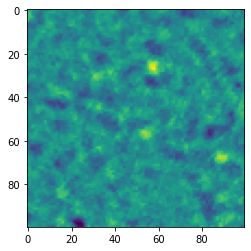

In [53]:
plt.imshow(new_frame)

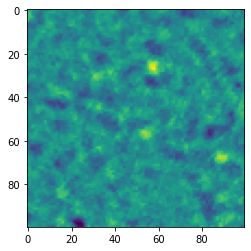

In [54]:
plt.imshow(data[0])